# Regression Week 4: Ridge Regression (gradient descent)

In this notebook, you will implement ridge regression via gradient descent. You will:
* Convert an SFrame into a Numpy array
* Write a Numpy function to compute the derivative of the regression weights with respect to a single feature
* Write gradient descent function to compute the regression weights given an initial weight vector, step size, tolerance, and L2 penalty

# Fire up graphlab create

Make sure you have the latest version of GraphLab Create (>= 1.7)

In [1]:
#import graphlab
import pandas as pd
import numpy as np
import sklearn
from sklearn.linear_model import LinearRegression, Ridge

# Load in house sales data

Dataset is from house sales in King County, the region where the city of Seattle, WA is located.

In [10]:
dtype_dict = {'bathrooms':float, 'waterfront':int, 'sqft_above':int, 'sqft_living15':float, 
              'grade':int, 'yr_renovated':int, 'price':float, 'bedrooms':float, 'zipcode':str, 
              'long':float, 'sqft_lot15':float, 'sqft_living':float, 'floors':float, 'condition':int, 
              'lat':float, 'date':str, 'sqft_basement':int, 'yr_built':int, 'id':str, 'sqft_lot':int, 'view':int}

sales = pd.read_csv('kc_house_data.csv', dtype=dtype_dict)
sales = sales.sort_values(['sqft_living','price'])

train_data = pd.read_csv('kc_house_train_data.csv', dtype=dtype_dict)
test_data  = pd.read_csv('kc_house_test_data.csv', dtype=dtype_dict)

If we want to do any "feature engineering" like creating new features or adjusting existing ones we should do this directly using the SFrames as seen in the first notebook of Week 2. For this notebook, however, we will work with the existing features.

# Import useful functions from previous notebook

As in Week 2, we convert the SFrame into a 2D Numpy array. Copy and paste `get_numpy_data()` from the second notebook of Week 2.

In [3]:
def get_numpy_data(data_sframe, features, output):
    n = len(output)
    data_sframe['constant'] = 1 
    features = ['constant'] + features  
    feature_matrix = data_sframe[features]
    output_array = data_sframe[output]
    return(feature_matrix, output_array)

Also, copy and paste the `predict_output()` function to compute the predictions for an entire matrix of features given the matrix and the weights:

In [4]:
def predict_output(feature_matrix, weights):
    predictions = np.dot(feature_matrix, weights)
    return(predictions)

# Computing the Derivative

We are now going to move to computing the derivative of the regression cost function. Recall that the cost function is the sum over the data points of the squared difference between an observed output and a predicted output, plus the L2 penalty term.
```
Cost(w)
= SUM[ (prediction - output)^2 ]
+ l2_penalty*(w[0]^2 + w[1]^2 + ... + w[k]^2).
```

Since the derivative of a sum is the sum of the derivatives, we can take the derivative of the first part (the RSS) as we did in the notebook for the unregularized case in Week 2 and add the derivative of the regularization part.  As we saw, the derivative of the RSS with respect to `w[i]` can be written as: 
```
2*SUM[ error*[feature_i] ].
```
The derivative of the regularization term with respect to `w[i]` is:
```
2*l2_penalty*w[i].
```
Summing both, we get
```
2*SUM[ error*[feature_i] ] + 2*l2_penalty*w[i].
```
That is, the derivative for the weight for feature i is the sum (over data points) of 2 times the product of the error and the feature itself, plus `2*l2_penalty*w[i]`. 

**We will not regularize the constant.**  Thus, in the case of the constant, the derivative is just twice the sum of the errors (without the `2*l2_penalty*w[0]` term).

Recall that twice the sum of the product of two vectors is just twice the dot product of the two vectors. Therefore the derivative for the weight for feature_i is just two times the dot product between the values of feature_i and the current errors, plus `2*l2_penalty*w[i]`.

With this in mind complete the following derivative function which computes the derivative of the weight given the value of the feature (over all data points) and the errors (over all data points).  To decide when to we are dealing with the constant (so we don't regularize it) we added the extra parameter to the call `feature_is_constant` which you should set to `True` when computing the derivative of the constant and `False` otherwise.

In [5]:
def feature_derivative_ridge(errors, feature, weight, l2_penalty, feature_is_constant):
    # If feature_is_constant is True, derivative is twice the dot product of errors and feature
    if feature_is_constant == True:
        derivative = 2 * np.dot(errors, feature)
    # Otherwise, derivative is twice the dot product plus 2*l2_penalty*weight
    else:
        derivative = 2 * np.dot(errors, feature) + 2*l2_penalty*weight
    return derivative


To test your feature derivartive run the following:

In [21]:
(example_features, example_output) = get_numpy_data(sales, ['sqft_living'], 'price') 
my_weights = np.array([1., 10.])
test_predictions = predict_output(example_features, my_weights) 
errors = test_predictions - example_output # prediction errors

# next two lines should print the same values
print feature_derivative_ridge(errors, example_features['sqft_living'], my_weights[1], 1, False)
print np.sum(errors*example_features['sqft_living'])*2+20.
print ''

# next two lines should print the same values
print feature_derivative_ridge(errors, example_features['constant'], my_weights[0], 1, True)
print np.sum(errors)*2.

-5.6554166816e+13
-5.6554166816e+13

-22446749330.0
-22446749330.0


# Gradient Descent

Now we will write a function that performs a gradient descent. The basic premise is simple. Given a starting point we update the current weights by moving in the negative gradient direction. Recall that the gradient is the direction of *increase* and therefore the negative gradient is the direction of *decrease* and we're trying to *minimize* a cost function. 

The amount by which we move in the negative gradient *direction*  is called the 'step size'. We stop when we are 'sufficiently close' to the optimum. Unlike in Week 2, this time we will set a **maximum number of iterations** and take gradient steps until we reach this maximum number. If no maximum number is supplied, the maximum should be set 100 by default. (Use default parameter values in Python.)

With this in mind, complete the following gradient descent function below using your derivative function above. For each step in the gradient descent, we update the weight for each feature before computing our stopping criteria.

Loop over each feature:

```python
def ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, 
                                      l2_penalty, max_iterations=100):
    print 'Starting gradient descent with l2_penalty = ' + str(l2_penalty)
    
    weights = np.array(initial_weights) # make sure it's a numpy array
    iteration = 0 # iteration counter
    print_frequency = 1  # for adjusting frequency of debugging output
    
    #while not reached maximum number of iterations:
    while (iteration <= max_iterations):
        
        # compute the predictions based on feature_matrix and weights using your predict_output() function
        predictions = np.dot(feature_matrix, weights)
         errors = predictions - output
        
        for i in xrange(len(weights)): # loop over each weight
            # Recall that feature_matrix[:,i] is the feature column associated with weights[i]
            # compute the derivative for weight[i].
            #(Remember: when i=0, you are computing the derivative of the constant!)
            if i== 0:  feature_is_constant = True
            else:      feature_is_constant = False
            derivative = feature_derivative_ridge(errors, feature_matrix.loc[:,feature_matrix.columns[i]], 
                                                  weights[i], l2_penalty, feature_is_constant)
            # subtract the step size times the derivative from the current weight
            weights[i] -= step_size* derivative
            
    print 'Done with gradient descent at iteration ', iteration
    print 'Learned weights = ', str(weights)
    return weights
```

In [11]:
def ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, 
                                      l2_penalty, max_iterations=100):
    print 'Starting gradient descent with l2_penalty = ' + str(l2_penalty)
    
    weights = np.array(initial_weights) # make sure it's a numpy array
    iteration = 0 # iteration counter
    print_frequency = 100  # for adjusting frequency of debugging output
    
    #while not reached maximum number of iterations:
    while (iteration < max_iterations):
        iteration += 1  # increment iteration counter
        ### === code section for adjusting frequency of debugging output. ===
        #if iteration == 10: print_frequency = 10
        if iteration == 100:
            print_frequency = 100
        if iteration%print_frequency==0:
            print('Iteration = ' + str(iteration))
        ### === end code section ===
        
        # compute the predictions based on feature_matrix and weights using your predict_output() function
        predictions = np.dot(feature_matrix, weights)
        # compute the errors as predictions - output
        errors = predictions - output
        # from time to time, print the value of the cost function
        if iteration%print_frequency==0:
            print 'Cost function = ', str(np.dot(errors,errors) + l2_penalty*(np.dot(weights,weights) - weights[0]**2))
        
        mat= np.eye(len(weights), len(weights))
        mat[0,0] = 0
        derivative = 2 * np.dot(errors, feature_matrix) + 2* l2_penalty* np.dot(mat, weights)
        # subtract the step size times the derivative from the current weight
        weights -= step_size* derivative
            
    print 'Done with gradient descent at iteration ', iteration
    print 'Learned weights = ', str(weights)
    return weights

# Visualizing effect of L2 penalty

The L2 penalty gets its name because it causes weights to have small L2 norms than otherwise. Let's see how large weights get penalized. Let us consider a simple model with 1 feature:

In [12]:
simple_features = ['sqft_living']
my_output = 'price'

Let us split the dataset into training set and test set. Make sure to use `seed=0`:
```python
train_data,test_data = sales.random_split(.8,seed=0)
```
In this part, we will only use `'sqft_living'` to predict `'price'`. Use the `get_numpy_data` function to get a Numpy versions of your data with only this feature, for both the `train_data` and the `test_data`. 

In [13]:
(simple_feature_matrix, output) = get_numpy_data(train_data, simple_features, my_output)
(simple_test_feature_matrix, test_output) = get_numpy_data(test_data, simple_features, my_output)

Let's set the parameters for our optimization:

In [14]:
initial_weights = np.array([0., 0.])
step_size = 1e-12
max_iterations=1000

First, let's consider no regularization.  Set the `l2_penalty` to `0.0` and run your ridge regression algorithm to learn the weights of your model.  Call your weights:

`simple_weights_0_penalty`

we'll use them later.

In [15]:
l2_penalty = 0.0
simple_weights_0_penalty = ridge_regression_gradient_descent(simple_feature_matrix, output, initial_weights, step_size, 
                                      l2_penalty, max_iterations= max_iterations)
simple_weights_0_penalty

Starting gradient descent with l2_penalty = 0.0
Iteration = 100
Cost function =  1.20825113613e+15
Iteration = 200
Cost function =  1.2082511289e+15
Iteration = 300
Cost function =  1.20825112168e+15
Iteration = 400
Cost function =  1.20825111445e+15
Iteration = 500
Cost function =  1.20825110722e+15
Iteration = 600
Cost function =  1.2082511e+15
Iteration = 700
Cost function =  1.20825109277e+15
Iteration = 800
Cost function =  1.20825108554e+15
Iteration = 900
Cost function =  1.20825107832e+15
Iteration = 1000
Cost function =  1.20825107109e+15
Done with gradient descent at iteration  1000
Learned weights =  [ -1.63113515e-01   2.63024369e+02]


array([ -1.63113515e-01,   2.63024369e+02])

Next, let's consider high regularization.  Set the `l2_penalty` to `1e11` and run your ridge regression algorithm to learn the weights of your model.  Call your weights:

`simple_weights_high_penalty`

we'll use them later.

In [16]:
simple_weights_high_penalty = ridge_regression_gradient_descent(simple_feature_matrix, output, initial_weights, step_size, 
                                      l2_penalty= 1e11 , max_iterations= max_iterations)
simple_weights_high_penalty

Starting gradient descent with l2_penalty = 1e+11
Iteration = 100
Cost function =  4.48484123471e+15
Iteration = 200
Cost function =  4.48483174081e+15
Iteration = 300
Cost function =  4.48482224695e+15
Iteration = 400
Cost function =  4.48481275313e+15
Iteration = 500
Cost function =  4.48480325935e+15
Iteration = 600
Cost function =  4.48479376561e+15
Iteration = 700
Cost function =  4.48478427191e+15
Iteration = 800
Cost function =  4.48477477824e+15
Iteration = 900
Cost function =  4.48476528462e+15
Iteration = 1000
Cost function =  4.48475579104e+15
Done with gradient descent at iteration  1000
Learned weights =  [   9.76730382  124.57217567]


array([   9.76730382,  124.57217567])

This code will plot the two learned models.  (The blue line is for the model with no regularization and the red line is for the one with high regularization.)

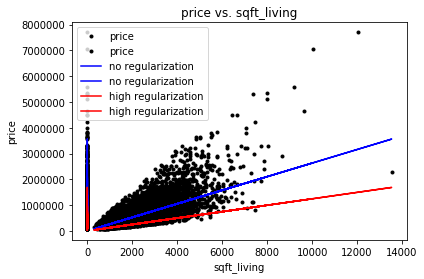

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(simple_feature_matrix,output,'k.' )
plt.plot(simple_feature_matrix,predict_output(simple_feature_matrix, simple_weights_0_penalty),'b-' , 
         label= 'no regularization')
plt.plot(simple_feature_matrix,predict_output(simple_feature_matrix, simple_weights_high_penalty),'r-', 
         label= 'high regularization')
plt.xlabel('sqft_living')
plt.ylabel('price')
plt.title('price vs. sqft_living')
plt.legend(loc= 2)

Compute the RSS on the TEST data for the following three sets of weights:
1. The initial weights (all zeros)
2. The weights learned with no regularization
3. The weights learned with high regularization

Which weights perform best?

In [18]:
initial_weights = np.array([0., 0.])

def comp_RSS(weights, data= simple_test_feature_matrix):
    errors =  np.dot(data, weights ) - test_output
    return np.dot( errors, errors)
    
print( initial_weights             , comp_RSS(initial_weights) )
print( simple_weights_0_penalty    , comp_RSS(simple_weights_0_penalty) )
print( simple_weights_high_penalty , comp_RSS(simple_weights_high_penalty) )

(array([ 0.,  0.]), 1784273286136298.0)
(array([ -1.63113515e-01,   2.63024369e+02]), 275723632153607.44)
(array([   9.76730382,  124.57217567]), 694642101489903.0)


In [19]:
np.log(np.dot(test_output, test_output))/np.log(10)

15.251461373342378

In [20]:
print ("{:.1f}".format(list(simple_weights_0_penalty)[1]), "{:.1f}".format(list(simple_weights_high_penalty)[1] ) )

('263.0', '124.6')


In [21]:
simp_linear = LinearRegression().fit(simple_feature_matrix, output)
simp_linear.coef_

/Users/qiaolinchen/Library/Python/2.7/lib/python/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


array([   0.        ,  281.95883963])

In [22]:
simp_ridge = Ridge(alpha= 0).fit(simple_feature_matrix, output )
simp_ridge.coef_

array([   0.        ,  281.95883963])

***QUIZ QUESTIONS***
1. What is the value of the coefficient for `sqft_living` that you learned with no regularization, rounded to 1 decimal place?  What about the one with high regularization?
2. Comparing the lines you fit with the with no regularization versus high regularization, which one is steeper?
3. What are the RSS on the test data for each of the set of weights above (initial, no regularization, high regularization)? 


# Running a multiple regression with L2 penalty

Let us now consider a model with 2 features: `['sqft_living', 'sqft_living15']`.

First, create Numpy versions of your training and test data with these two features. 

In [23]:
model_features = ['sqft_living', 'sqft_living15'] # sqft_living15 is the average squarefeet for the nearest 15 neighbors. 
my_output = 'price'
(feature_matrix, output) = get_numpy_data(train_data, model_features, my_output)
(test_feature_matrix, test_output) = get_numpy_data(test_data, model_features, my_output)

We need to re-inialize the weights, since we have one extra parameter. Let us also set the step size and maximum number of iterations.

In [24]:
initial_weights = np.array([0.0,0.0,0.0])
step_size = 1e-12
max_iterations = 1000

First, let's consider no regularization.  Set the `l2_penalty` to `0.0` and run your ridge regression algorithm to learn the weights of your model.  Call your weights:

`multiple_weights_0_penalty`

In [25]:
l2_penalty=0
multiple_weights_0_penalty = ridge_regression_gradient_descent(feature_matrix, output, initial_weights, 
                                                               step_size,  l2_penalty, max_iterations )

Starting gradient descent with l2_penalty = 0
Iteration = 100
Cost function =  1.22575873839e+15
Iteration = 200
Cost function =  1.21173888029e+15
Iteration = 300
Cost function =  1.20747307976e+15
Iteration = 400
Cost function =  1.20617512454e+15
Iteration = 500
Cost function =  1.205780189e+15
Iteration = 600
Cost function =  1.20566001323e+15
Iteration = 700
Cost function =  1.20562343801e+15
Iteration = 800
Cost function =  1.20561229974e+15
Iteration = 900
Cost function =  1.20560890112e+15
Iteration = 1000
Cost function =  1.20560785742e+15
Done with gradient descent at iteration  1000
Learned weights =  [  -0.35743483  243.05416982   22.41481497]


Next, let's consider high regularization.  Set the `l2_penalty` to `1e11` and run your ridge regression algorithm to learn the weights of your model.  Call your weights:

`multiple_weights_high_penalty`

In [26]:
l2_penalty = 1e11 
multiple_weights_high_penalty = ridge_regression_gradient_descent(feature_matrix, output, initial_weights, 
                                                               step_size,  l2_penalty, max_iterations )

Starting gradient descent with l2_penalty = 1e+11
Iteration = 100
Cost function =  3.60529037346e+15
Iteration = 200
Cost function =  3.60528585733e+15
Iteration = 300
Cost function =  3.60528134121e+15
Iteration = 400
Cost function =  3.60527682511e+15
Iteration = 500
Cost function =  3.60527230902e+15
Iteration = 600
Cost function =  3.60526779294e+15
Iteration = 700
Cost function =  3.60526327688e+15
Iteration = 800
Cost function =  3.60525876083e+15
Iteration = 900
Cost function =  3.6052542448e+15
Iteration = 1000
Cost function =  3.60524972878e+15
Done with gradient descent at iteration  1000
Learned weights =  [  6.74296579  91.48927365  78.43658766]


Compute the RSS on the TEST data for the following three sets of weights:
1. The initial weights (all zeros)
2. The weights learned with no regularization
3. The weights learned with high regularization

Which weights perform best?

In [27]:
np.dot(feature_matrix, initial_weights ).shape, test_output.shape


((17384,), (4229,))

In [28]:
def comp_RSS(weights, data ):
    errors =  np.dot(data, weights ) - test_output
    return np.dot( errors, errors)

print( initial_weights               , comp_RSS(initial_weights            , data= test_feature_matrix) )
print( multiple_weights_0_penalty    , comp_RSS(multiple_weights_0_penalty   , data= test_feature_matrix) )
print( multiple_weights_high_penalty , comp_RSS(multiple_weights_high_penalty, data= test_feature_matrix) )

(array([ 0.,  0.,  0.]), 1784273286136298.0)
(array([  -0.35743483,  243.05416982,   22.41481497]), 274067615918575.56)
(array([  6.74296579,  91.48927365,  78.43658766]), 500404800500841.25)


In [34]:
np.log(274067615918575.56)/ np.log(10)

14.437857721935876

In [30]:
print("{:.1f}".format( list(multiple_weights_0_penalty)[1] ))
print("{:.1f}".format(list(multiple_weights_high_penalty)[1]))

243.1
91.5


Predict the house price for the 1st house in the test set using the no regularization and high regularization models. (Remember that python starts indexing from 0.) How far is the prediction from the actual price?  Which weights perform best for the 1st house?

In [31]:
np.dot(test_feature_matrix.iloc[0], multiple_weights_0_penalty )

387465.47605823533

In [32]:
np.dot(test_feature_matrix.iloc[0], multiple_weights_high_penalty )

270453.53032194078

In [33]:
test_output[0]

310000.0

***QUIZ QUESTIONS***
1. What is the value of the coefficient for `sqft_living` that you learned with no regularization, rounded to 1 decimal place?  What about the one with high regularization?
2. What are the RSS on the test data for each of the set of weights above (initial, no regularization, high regularization)? 
3. We make prediction for the first house in the test set using two sets of weights (no regularization vs high regularization). Which weights make better prediction <u>for that particular house</u>?